In [1]:
import fastbook
fastbook.setup_book()
import os
# import torch
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# torch.rand(1).cuda()

In [2]:
from fastai.vision.all import *
import pandas as pd
import ipywidgets as widgets

In [3]:
top_edge=tensor([[-1,-1,-1],
                [0,0,0],
                [1,1,1]]).float()

In [4]:
path=Path('Train/MnistScans')

<AxesSubplot:>

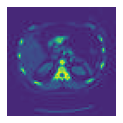

In [5]:
im=Image.open(path/'AbdomenCT'/'000000.jpeg')
show_image(im)

In [6]:
im_t=tensor(im)
im_t[0:3,0:3]*top_edge

tensor([[-101., -101., -101.],
        [   0.,    0.,    0.],
        [ 101.,  101.,  101.]])

In [7]:
(im_t[0:3,0:3]*top_edge).sum()

tensor(0.)

In [8]:
df=pd.DataFrame(im_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,103,102,102,101,101,102,103,103,101,101,101,101,101,101,101,101
1,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,102,101,101,101,101,102,103,103,101,101,101,101,101,101,101,101
2,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,100,100,100,100,100,101,102,103,101,101,101,101,101,101,101,101
3,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,100,100,100,100,100,101,102,103,101,101,101,101,101,101,101,101
4,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,102,101,101,100,100,101,101,102,101,101,101,101,101,101,101,101
5,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,105,104,103,102,101,101,101,101,101,101,101,101,101,101,101,101
6,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,108,107,105,103,102,101,100,100,101,101,101,101,101,101,101,101
7,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,111,109,107,104,102,101,100,99,101,101,101,101,101,101,101,101
8,101,101,101,101,101,101,101,101,95,107,108,97,95,105,106,97,101,102,103,103,102,101,101,101,100,100,100,101,101,102,102,102,102,102,102,103,103,104,104,104,103,103,103,101,99,98,99,101,97,99,104,108,105,98,98,102,104,104,103,101,100,100,102,104
9,101,101,101,101,101,101,101,101,105,99,94,96,103,107,100,91,96,95,95,97,101,105,109,110,111,111,109,108,106,104,103,102,102,103,105,107,110,113,114,116,103,103,103,102,102,106,111,115,112,103,93,93,102,108,107,102,102,102,102,101,100,100,102,103


In [9]:
(im_t[17:20,24:27]*top_edge).sum()

tensor(58.)

In [10]:
(im_t[22:25,32:35]*top_edge).sum()

tensor(61.)

In [11]:
def apply_kernel(row,col,kernel):
    return (im_t[row-1:row+2,col-1:col+2]*kernel).sum()

In [12]:
[[(i,j) for j in range(1,5)] for i in range(1,5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

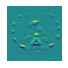

In [13]:
rng=range(1,60)
top_edge1=tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
show_image(top_edge1);

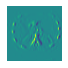

In [14]:
left_edge=tensor([[-1,1,0],
                 [-1,1,0],
                 [-1,1,0]]).float()
left_edge1=tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge1);

In [15]:
diag1_edge=tensor([[0,-1,1],
                 [-1,1,0],
                 [1,0,0]]).float()
diag2_edge=tensor([[1,-1,0],
                  [0,1,-1],
                  [0,1,1]]).float()
edge_kernels=torch.stack([left_edge,top_edge,diag1_edge,diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [16]:
mnist=DataBlock((ImageBlock(cls=PILImageBW),CategoryBlock),
               get_items=get_image_files,
               splitter=RandomSplitter(),
               get_y=parent_label)
dls=mnist.dataloaders(path)
xb,yb=first(dls.valid)
xb.shape

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


torch.Size([64, 1, 64, 64])

In [17]:
xb,yb=to_cpu(xb),to_cpu(yb)

In [18]:
edge_kernels.shape,edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [19]:
edge_kernels=edge_kernels.unsqueeze(1)

In [20]:
batch_features=F.conv2d(xb,edge_kernels)
batch_features.shape

torch.Size([64, 4, 62, 62])

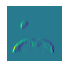

In [21]:
show_image(batch_features[0,0]);

In [22]:
simple_net=nn.Sequential(
nn.Linear(28*28,30),
nn.ReLU(),
nn.Linear(30,1))

In [23]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [24]:
broken_cnn=sequential(
nn.Conv2d(1,30,kernel_size=3,padding=1),
nn.ReLU(),
nn.Conv2d(30,1,kernel_size=3,padding=1))

In [25]:
broken_cnn(xb).shape

torch.Size([64, 1, 64, 64])

In [26]:
def conv(ni,nf,ks=3,act=True):
    res=nn.Conv2d(ni,nf,stride=2,kernel_size=ks,padding=ks//2)
    if act: res=nn.Sequential(res,nn.ReLU())
    return res

In [27]:
simple_cnn=sequential(
conv(1,4),
conv(4,8),
conv(8,16),
conv(16,32),
conv(32,2,act=False),
Flatten(),
)

In [28]:
simple_cnn(xb).shape

torch.Size([64, 8])

In [29]:
learn=Learner(dls,simple_cnn,loss_func=CrossEntropyLossFlat(),metrics=accuracy)
learn.summary()

Sequential (Input shape: 64 x 1 x 64 x 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 32 x 32    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 16 x 16    
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 8 x 8     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 4 x 4     
Conv2d                                    4640       True      
ReLU                                          

In [30]:
learn.fit_one_cycle(2,0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.046394,0.032099,0.993469,19:18
1,0.013367,0.012578,0.997286,01:25


In [31]:
# learn.export(fname='MedicalMNIST.pkl')

In [32]:
# path=Path()
# path.ls(file_exts='.pkl')

In [33]:
# learn_inf=load_learner(path/'MedicalMNIST.pkl')

In [34]:
# pred_img=Image.open(path/'cars'/'abdomen2.png')
# show_image(pred_img)

In [35]:
# pred_img.to_thumb(64)

In [36]:
# learn_inf.predict(path/'cars'/'chest2.png')

In [37]:
def get_dls(bs=15):
    return DataBlock(
    blocks=(ImageBlock(cls=PILImageBW),CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label,
    batch_tfms=Normalize()
    ).dataloaders(path,bs=bs)
dls=get_dls()

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


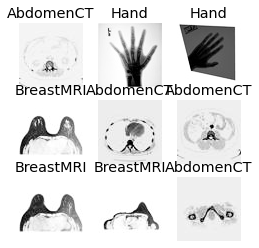

In [38]:
dls.show_batch(max_n=9,figsize=(4,4))

In [39]:
def conv(ni,nf,ks=3,act=True):
    res=nn.Conv2d(ni,nf,stride=2,kernel_size=ks,padding=ks//2)
    if act: res=nn.Sequential(res,nn.ReLU())
    return res

In [40]:
def simple_cnn():
    return sequential(
    conv(1,8,ks=5),
    conv(8,16),
    conv(16,32),
    conv(32,64),
    conv(64,10,act=False),
    Flatten(),
    )

In [41]:
from fastai.callback.hook import *

In [42]:
def fit(epochs=1):
    learn=Learner(dls,simple_cnn(),loss_func=CrossEntropyLossFlat(),
                 metrics=accuracy,cbs=ActivationStats(with_hist=True))
    learn.fit(epochs,0.06)
    return learn

In [43]:
learn=fit()

C:\Users\mayan\anaconda3\envs\GPU\lib\site-packages\fastai\callback\core.py:51: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,1.798655,1.796562,0.164970,02:15


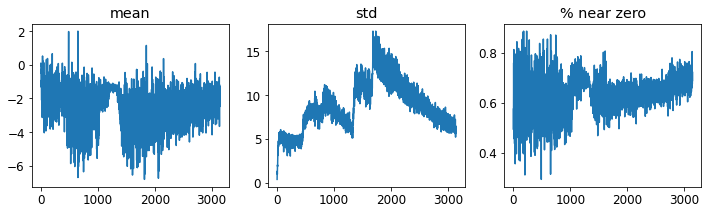

In [44]:
learn.activation_stats.plot_layer_stats(0)

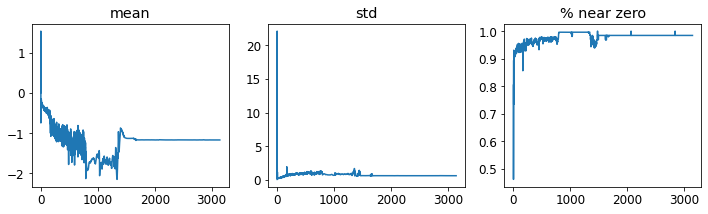

In [45]:
learn.activation_stats.plot_layer_stats(-2)

In [46]:
dls=get_dls(512)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [47]:
learn=fit()

epoch,train_loss,valid_loss,accuracy,time
0,3.282431,1.791450,0.166921,01:08


In [48]:
def fit(epochs=1,lr=0.06):
    learn=Learner(dls,simple_cnn(),loss_func=CrossEntropyLossFlat(),
                 metrics=accuracy,cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs,lr)
    return learn

In [49]:
learn=fit()

epoch,train_loss,valid_loss,accuracy,time
0,1.885108,1.792913,0.173876,01:09


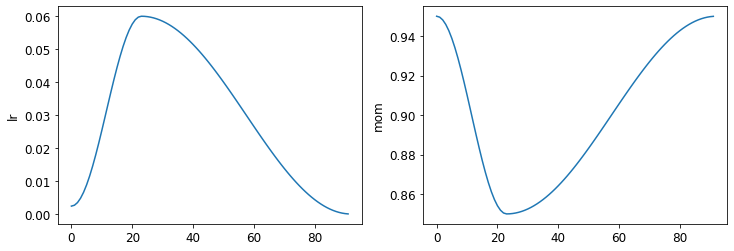

In [50]:
learn.recorder.plot_sched()

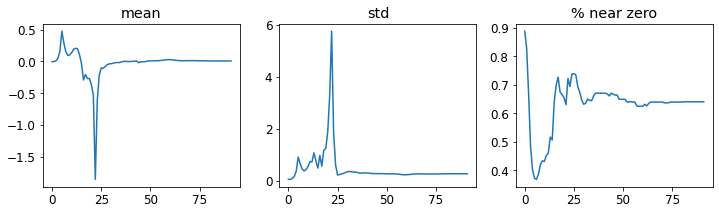

In [51]:
learn.activation_stats.plot_layer_stats(-2)

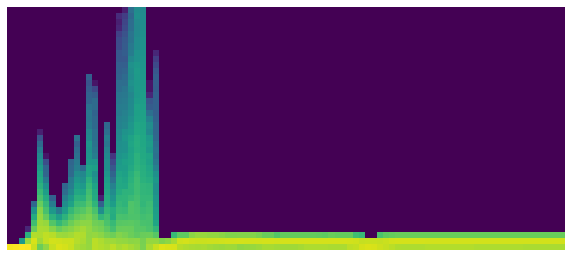

In [52]:
learn.activation_stats.color_dim(-2)

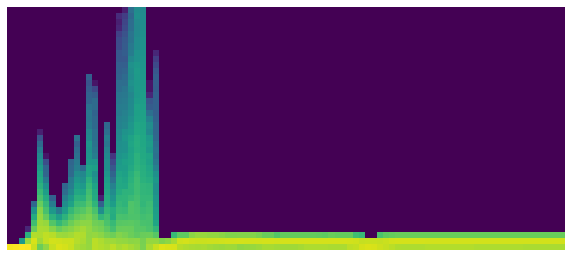

In [53]:
learn.activation_stats.color_dim(-2)

In [54]:
def conv(ni,nf,ks=3,act=True):
    layers=[nn.Conv2d(ni,nf,stride=2,kernel_size=ks,padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [55]:
learn=fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.223733,0.044253,0.997371,01:18


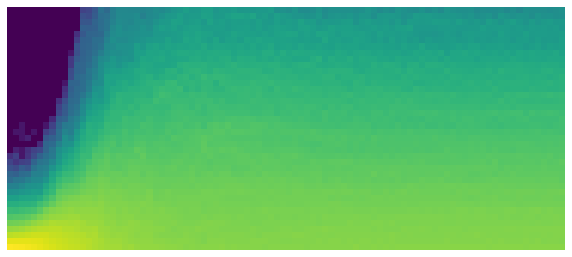

In [56]:
learn.activation_stats.color_dim(-4)

In [57]:
learn=fit(5,lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.370496,0.083308,0.984563,01:17
1,0.219614,0.552004,0.858863,01:17
2,0.064557,0.032768,0.992791,01:17
3,0.024574,0.016365,0.996183,01:18
4,0.014161,0.013067,0.997540,01:18


In [63]:
learn.export(fname='MedicalMNIST(B).pkl')

In [64]:
path=Path()
path.ls(file_exts='.pkl')

(#6) [Path('FacialAge.pkl'),Path('MedicalMNIST(A).pkl'),Path('MedicalMNIST(B).pkl'),Path('MedicalMNIST.pkl'),Path('StandFordCar.pkl'),Path('VGames.pkl')]

In [65]:
learn_inf=load_learner(path/'MedicalMNIST(B).pkl')

In [66]:
btn_upload=widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [94]:
img=PILImageBW.create(btn_upload.data[-1])

In [95]:
out_pl=widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(64,64))
out_pl

Output()

In [96]:
pred=learn_inf.predict(img)
pred

('BreastMRI',
 TensorBase(1),
 TensorBase([1.9892e-03, 9.8632e-01, 9.4542e-04, 3.6549e-05, 1.0905e-03, 2.9382e-04, 7.1208e-03, 2.8899e-07, 6.5144e-05, 9.6261e-05, 7.5440e-05, 7.9870e-05, 7.0410e-05, 8.9752e-05, 5.4443e-05, 4.5599e-05,
         7.9534e-05, 1.0406e-04, 5.9991e-05, 5.8158e-05, 7.1692e-05, 9.2480e-05, 5.1990e-05, 5.3704e-05, 6.5928e-05, 8.0863e-05, 4.9035e-05, 5.1282e-05, 7.6062e-05, 9.3558e-05, 4.2328e-05, 4.9337e-05,
         7.6033e-05, 1.1001e-04, 4.5499e-05, 5.1809e-05, 7.5631e-05, 8.3400e-05, 5.2591e-05, 5.1315e-05]))